# ODE integration for a stiff problem.

Vijay Varma (Albert-Einstein-Institute).  
Prepared for the Computational Physics IMPRS Course (2022).

Demonstrate explicit and implicit methods for a stiff ODE.

In [1]:
import sys
import os
import math
import numpy as np
import scipy
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

## Setup the RHS, the exact solution

In [2]:
def func(t, y):
    """ This function returns the RHS of the differential equation 
    dy/dt = func(t, y), for which the solution is y = exact_sol(t) below.
    """
    u = y[0]
    v = y[1]
    dudt = 998 * u + 1998 * v
    dvdt = -999 * u - 1999 * v
    return [dudt, dvdt]

def exact_sol(t):
    """ Exact solution for a test case, chosen because that it has
        wildy different time scales: a stiff problem.
    """
    u = 2 * np.exp(-t) - np.exp(-1000 * t)
    v = -np.exp(-t) + np.exp(-1000 * t)
    y = [u, v]
    return y

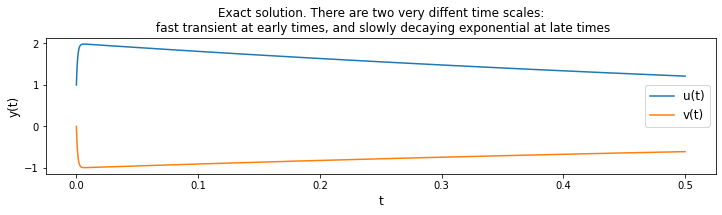

In [3]:
# Let's examine what the problem looks like
t_tmp = np.linspace(0, 0.5, 1000)
plt.figure(0, figsize=(12, 2.5))
plt.plot(t_tmp, exact_sol(t_tmp)[0], label='u(t)')
plt.plot(t_tmp, exact_sol(t_tmp)[1], label='v(t)')
plt.xlabel('t', fontsize=12)
plt.ylabel('y(t)', fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.title('Exact solution. There are two very diffent '
          'time scales:\n fast transient at early times, '
          'and slowly decaying exponential at late times', fontsize=12);

## Setup ODE options

In [4]:
# ODE method to use. 
# Let's start with an explicit method, RK45, a 5th order RK method
# with adaptive time stepping (the error is estimated using an 
# embedded 4th order by combining embedded order RK method.) 
# See https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html
# for more options.
method_exp = 'RK45'   

t0 = 0                   # Start time
tmax = 0.5               # End time
y0 = exact_sol(t0)       # initial value

## Experiment with fixed h for an explicit method

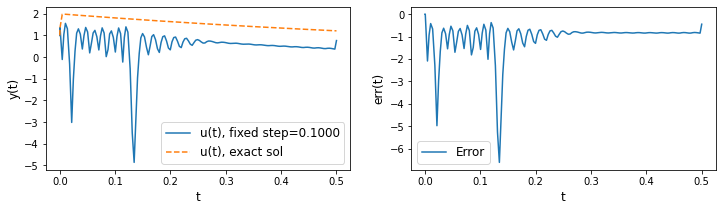

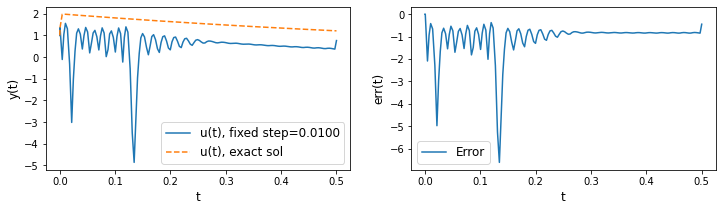

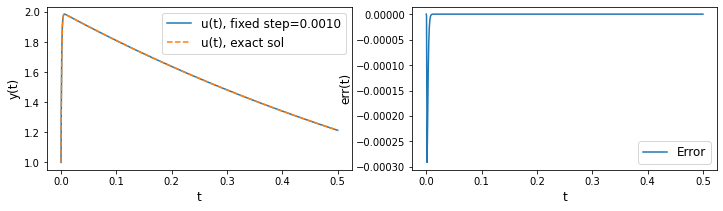

In [5]:
# Loop over different fixed time steps and solve the ODE.
# Note that the solution is unstable unless h ~< 1/1000,
# the time scale of the fast transient in exaxt_sol(t).
h_vec = [0.1, 0.01, 0.001]
for idx, h0 in enumerate(h_vec):
    # NOTE: By setting rtol=atol=1 and max_step=h, 
    # we trick solve_ivp to always use a fixed time step. 
    sol = solve_ivp(func, [t0, tmax], y0, rtol=1, atol=1, 
                max_step=h0, method=method_exp)
    t_fixed = sol.t
    y_fixed = sol.y

    plt.figure(idx, figsize=(12, 3))
    plt.subplot(1, 2, 1)
    # Let's just plot u(t) for convenience
    plt.plot(t_fixed, y_fixed[0], 
             label=f'u(t), fixed step={h0:.4f}')
    plt.plot(t_fixed, exact_sol(t_fixed)[0], ls='dashed', 
             label='u(t), exact sol')
    plt.legend(fontsize=12, loc='best')
    plt.xlabel('t', fontsize=12)
    plt.ylabel('y(t)', fontsize=12)
    
    plt.subplot(1, 2, 2)
    plt.plot(t_fixed, y_fixed[0] - exact_sol(t_fixed)[0], label='Error')
    plt.legend(fontsize=12, loc='best')
    plt.xlabel('t', fontsize=12)
    plt.ylabel('err(t)', fontsize=12)


## Now try adaptive h for an explicit method

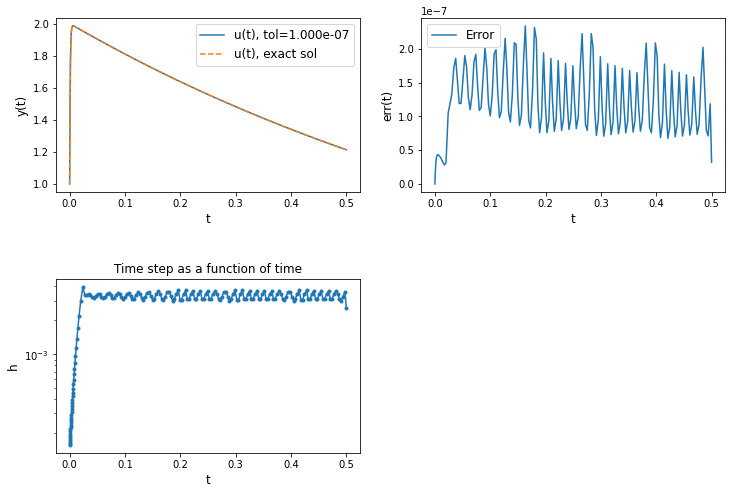

In [6]:
# Now solve the same problem with an adaptize step size, at the 
# given tolernace. We now use dense_output so that we can interpolate
# the solution to any desired time array
target_tol = 1e-7
sol = solve_ivp(func, [t0, tmax], y0, atol=target_tol, rtol=target_tol,
                dense_output=True, method=method_exp)
t_adapt_ex = sol.t
y_adapt_ex = sol.y
err_ex = np.abs(y_adapt_ex[0] - exact_sol(t_adapt_ex)[0])

plt.figure(0, figsize=(12, 8))
matplotlib.pyplot.subplots_adjust(wspace=0.2, hspace=0.5)

plt.subplot(2, 2, 1)
plt.plot(t_adapt_ex, y_adapt_ex[0], label=f'u(t), tol={target_tol:.3e}')
plt.plot(t_adapt_ex, exact_sol(t_adapt_ex)[0], ls='dashed', 
         label='u(t), exact sol')
plt.legend(fontsize=12, loc='best')
plt.xlabel('t', fontsize=12)
plt.ylabel('y(t)', fontsize=12)
    
plt.subplot(2, 2, 2)
plt.plot(t_adapt_ex, err_ex, label='Error')
plt.legend(fontsize=12, loc='best')
plt.xlabel('t', fontsize=12)
plt.ylabel('err(t)', fontsize=12)

# How does the time step change?
plt.subplot(2, 2, 3)
plt.semilogy(t_adapt_ex[1:], np.diff(t_adapt_ex), marker='.')
plt.xlabel('t', fontsize=12)
plt.ylabel('h', fontsize=12)
plt.title('Time step as a function of time');


## Finally, try an implicit method

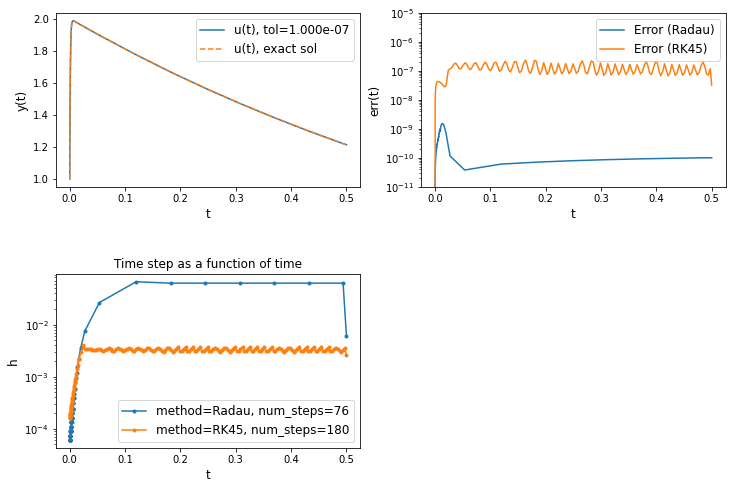

In [7]:
# Now solve the same problem with an implicit method
method_imp = 'Radau'
sol = solve_ivp(func, [t0, tmax], y0, atol=target_tol, rtol=target_tol,
                dense_output=True, method=method_imp)
t_adapt_im = sol.t
y_adapt_im = sol.y
err_im = np.abs(y_adapt_im[0] - exact_sol(t_adapt_im)[0])

plt.figure(0, figsize=(12, 8))
matplotlib.pyplot.subplots_adjust(wspace=0.2, hspace=0.5)

plt.subplot(2, 2, 1)
plt.plot(t_adapt_im, y_adapt_im[0], 
         label=f'u(t), tol={target_tol:.3e}')
plt.plot(t_adapt_im, exact_sol(t_adapt_im)[0], ls='dashed', 
         label='u(t), exact sol')
plt.legend(fontsize=12, loc='best')
plt.xlabel('t', fontsize=12)
plt.ylabel('y(t)', fontsize=12)
    
# For some reason, the implicit solver has an error well below
# the target_tol. This might mean the error estimate for this method
# is not working well for this problem? Using method='BDF' seems to fix
# this.
plt.subplot(2, 2, 2)
plt.semilogy(t_adapt_im, err_im, label=f'Error ({method_imp})')
plt.semilogy(t_adapt_ex, err_ex, label=f'Error ({method_exp})')
plt.legend(fontsize=12, loc='best')
plt.xlabel('t', fontsize=12)
plt.ylabel('err(t)', fontsize=12)
plt.ylim(1e-11, 1e-5)

# How does the time step change? Notice how the implicit solver
# manages to take big steps once the transient is gone, while the
# explicit solver still continues to take steps <~ 5e-3. The
# explicit solver needs to do this to remain stable, but the
# implicit solver doesn't!
plt.subplot(2, 2, 3)
plt.semilogy(t_adapt_im[1:], np.diff(t_adapt_im), marker='.', 
             label=f'method={method_imp}, num_steps={len(t_adapt_im)}')
plt.semilogy(t_adapt_ex[1:], np.diff(t_adapt_ex), marker='.', 
             label=f'method={method_exp}, num_steps={len(t_adapt_ex)}')
plt.xlabel('t', fontsize=12)
plt.ylabel('h', fontsize=12)
plt.legend(fontsize=12, loc='best')
plt.title('Time step as a function of time');

## Comparison over a longer evolution

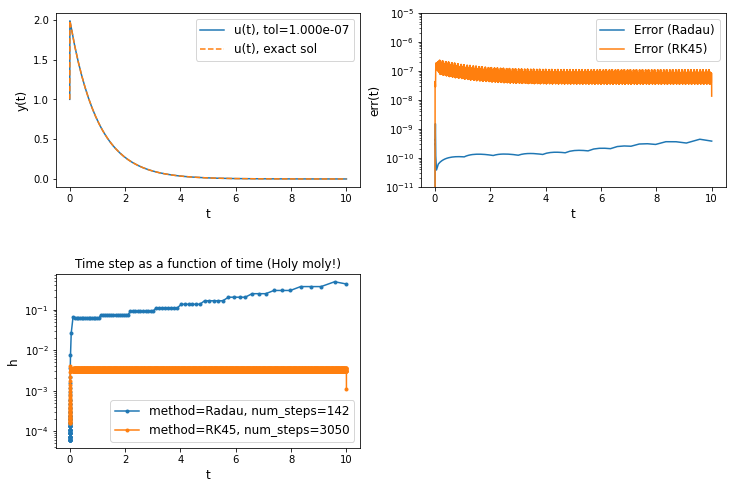

In [8]:
# To drive the point home, let's let the solver run for longer
tmax = 10

## The rest of this cell is just a repeat of the above code

sol = solve_ivp(func, [t0, tmax], y0, atol=target_tol, rtol=target_tol,
                dense_output=True, method=method_exp)
t_adapt_ex = sol.t
y_adapt_ex = sol.y
err_ex = np.abs(y_adapt_ex[0] - exact_sol(t_adapt_ex)[0])

sol = solve_ivp(func, [t0, tmax], y0, atol=target_tol, rtol=target_tol,
                dense_output=True, method=method_imp)
t_adapt_im = sol.t
y_adapt_im = sol.y
err_im = np.abs(y_adapt_im[0] - exact_sol(t_adapt_im)[0])

plt.figure(0, figsize=(12, 8))
matplotlib.pyplot.subplots_adjust(wspace=0.2, hspace=0.5)

plt.subplot(2, 2, 1)
plt.plot(t_adapt_im, y_adapt_im[0], 
         label=f'u(t), tol={target_tol:.3e}')
plt.plot(t_adapt_im, exact_sol(t_adapt_im)[0], ls='dashed', 
         label='u(t), exact sol')
plt.legend(fontsize=12, loc='best')
plt.xlabel('t', fontsize=12)
plt.ylabel('y(t)', fontsize=12)
    
plt.subplot(2, 2, 2)
plt.semilogy(t_adapt_im, err_im, label=f'Error ({method_imp})')
plt.semilogy(t_adapt_ex, err_ex, label=f'Error ({method_exp})')
plt.legend(fontsize=12, loc='best')
plt.xlabel('t', fontsize=12)
plt.ylabel('err(t)', fontsize=12)
plt.ylim(1e-11, 1e-5)

# How does the time step change?
plt.subplot(2, 2, 3)
plt.semilogy(t_adapt_im[1:], np.diff(t_adapt_im), marker='.', 
             label=f'method={method_imp}, num_steps={len(t_adapt_im)}')
plt.semilogy(t_adapt_ex[1:], np.diff(t_adapt_ex), marker='.', 
             label=f'method={method_exp}, num_steps={len(t_adapt_ex)}')
plt.xlabel('t', fontsize=12)
plt.ylabel('h', fontsize=12)
plt.legend(fontsize=12, loc='best')
plt.title('Time step as a function of time (Holy moly!)');